In [1]:
%cd ..

/scratch/gpfs/zzada/fconv


In [7]:
from glob import glob

import pickle
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
# from nilearn import datasets
# from nilearn.maskers import NiftiMasker, NiftiLabelsMasker
from util.path import Path
from util import subject
from constants import RUNS, NRUNS, TR, CONFOUNDS

In [18]:
sub = 4
run = None
trial = None
item = None
first = None
conv = subject.get_conv(sub)

# Visualize transcript

In [33]:
eventpath = Path(
    root="stimuli",
    conv=conv,
    datatype="transcript",
    run=run,
    trial=trial if trial is not None else None,
    item=item,
    condition=None,
    first=first,
    suffix="aligned",
    ext=".csv",
)
eventpath

stimuli/conv-104/transcript/conv-104_aligned.csv

In [40]:
search_str = eventpath.starstr(['conv', 'datatype'])
print(search_str)
files = glob(search_str)
for fn in files:
    print(fn)

stimuli/conv-104/transcript/conv-104*_aligned.csv
stimuli/conv-104/transcript/conv-104_run-5_set-3_trial-19_item-20_condition-G_first-A_aligned.csv
stimuli/conv-104/transcript/conv-104_run-4_set-3_trial-16_item-15_condition-G_first-A_aligned.csv
stimuli/conv-104/transcript/conv-104_run-3_set-2_trial-11_item-11_condition-G_first-B_aligned.csv
stimuli/conv-104/transcript/conv-104_run-2_set-1_trial-6_item-5_condition-G_first-A_aligned.csv
stimuli/conv-104/transcript/conv-104_run-1_set-1_trial-1_item-2_condition-G_first-A_aligned.csv
stimuli/conv-104/transcript/conv-104_run-2_set-1_trial-7_item-8_condition-G_first-A_aligned.csv
stimuli/conv-104/transcript/conv-104_run-4_set-2_trial-13_item-13_condition-G_first-A_aligned.csv
stimuli/conv-104/transcript/conv-104_run-5_set-3_trial-18_item-17_condition-G_first-B_aligned.csv
stimuli/conv-104/transcript/conv-104_run-3_set-2_trial-10_item-9_condition-G_first-B_aligned.csv
stimuli/conv-104/transcript/conv-104_run-1_set-1_trial-4_item-4_condition-G

In [52]:
eventpath = Path.frompath(files[0].split('/')[-1])
eventpath.update(root='stimuli', datatype='transcript')
eventpath

stimuli/conv-104/transcript/conv-104_run-5_set-3_trial-19_item-20_condition-G_first-A_aligned.csv

In [53]:
df = pd.read_csv(eventpath)
df.ffill(inplace=True)
df

,speaker,sentence,word,start,end,score
0,4,1,Um...,2.341,2.482,0.746
1,4,1,can,4.108,4.229,0.523
2,4,1,you,4.249,4.369,0.778
3,4,1,summarize,4.390,4.751,0.528
4,4,1,the,4.791,4.871,0.953
...,...,...,...,...,...,...
490,4,2,it,176.524,176.597,0.252
491,4,2,definitely,176.645,177.224,0.413
492,4,2,plays,177.297,177.562,0.735
493,4,2,a,177.659,177.900,0.576


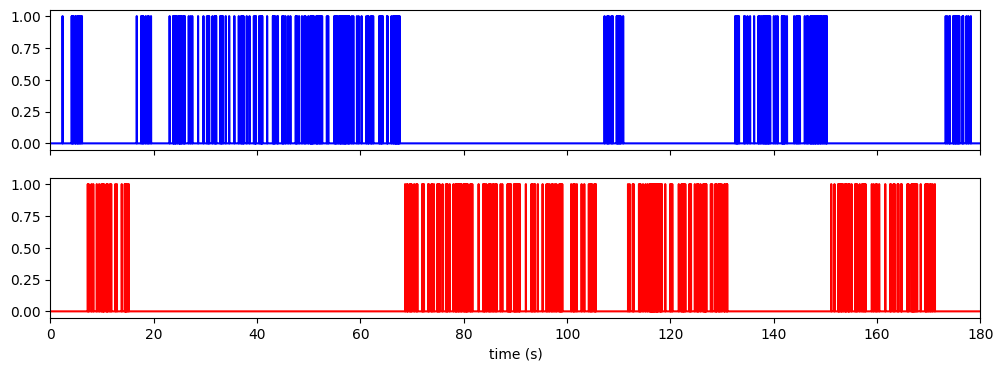

In [56]:
xaxis = np.arange(180 * 1000) / 1000

upto = int(df.start.max() * 1000) + 1
subA = np.zeros(180000)
subA[(df[df.speaker == sub].start * 1000).astype(int)] = 1

subB = np.zeros_like(subA)
subB[(df[df.speaker != sub].start * 1000).astype(int)] = 1

fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
axes[0].set_xlim(0, 180)
axes[0].plot(xaxis, subA, color="blue")
axes[1].plot(xaxis, subB, color="red")
axes[1].set_xlabel("time (s)")
fig.show()

# Visualize brain

In [57]:
eventpath

stimuli/conv-104/transcript/conv-104_run-5_set-3_trial-19_item-20_condition-G_first-A_aligned.csv

In [61]:
run = eventpath['run']
trial = ((int(eventpath["trial"]) - 1) % 4) + 1
slices = [slice(i, i+240) for i in range(0, 1200, 240)]
run, trial

(5, 3)

In [89]:
from scipy.signal import resample
from encoding import build_regressors

In [91]:
X, _ = build_regressors(sub, modelname='model-gpt2-medium_layer-0.75')
X.shape

(1200, 2051)

In [94]:
id_vars = X[slices[run-1], :2][:120]
id_vars.shape

(120, 2)

In [77]:
# dfemb = subject.get_transcript(sub, modelname='model-gpt2-medium_layer-0.75')
# df2 = dfemb[(dfemb.run == run) & (dfemb.trial == eventpath['trial'])]
# df2['word,speaker,sentence,start'.split(',')]

In [72]:
data = subject.get_bold(sub)
run_data = data[slices[run-1]]
trial_data = run_data[:120] # get first trial always (can fix later)
trial_data.shape

(120, 81924)

In [100]:
dataB = subject.get_bold(subject.get_partner(sub))
run_dataB = dataB[slices[run-1]]
trial_dataB = run_dataB[:120] # get first trial always (can fix later)
trial_dataB.shape

(120, 81924)

In [126]:
import seaborn as sns
from scipy.io import wavfile
from scipy.stats import zscore

In [112]:
audiopath = eventpath.copy()
audiopath.update(datatype='audio', suffix=None, ext='.wav')
fs, audio_data = wavfile.read(audiopath)
audio_data.shape

stimuli/conv-104/audio/conv-104_run-5_set-3_trial-19_item-20_condition-G_first-A.wav

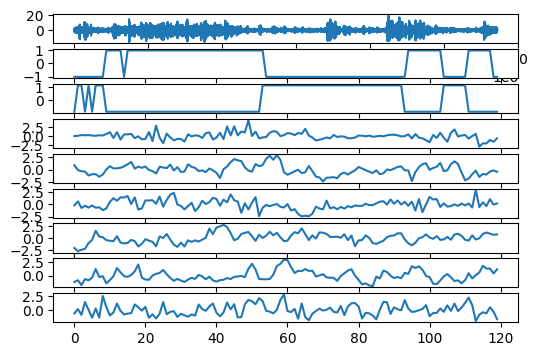

In [127]:
fig, axes = plt.subplots(9, 1, figsize=(6, 4))
axes[0].plot(zscore(audio_data))
axes[1+0].plot(zscore(id_vars[:, 0]))
axes[1+1].plot(zscore(id_vars[:, 1]))
axes[1+2].plot(zscore(trial_data[:, 1]))
axes[1+3].plot(zscore(trial_data[:, 0]))
axes[1+4].plot(zscore(trial_data[:, 3]))
axes[1+5].plot(zscore(trial_dataB[:, 1]))
axes[1+6].plot(zscore(trial_dataB[:, 0]))
axes[1+7].plot(zscore(trial_dataB[:, 300]))
fig.savefig('figures/fig1-artifacts.svg')
fig.show()